In [ ]:
!apt-get install openjdk-8-jdk-headless
!wget https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
!tar xf spark-3.2.1-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:
import pyspark.pandas as ps
from pyspark.sql.functions import *
import pandas as pd

In [ ]:
#Load all datasets into spark
df_users = spark.read.csv("/content/users.csv", header=True, inferSchema=True)
df_userSession = spark.read.csv("/content/user-session.csv", header=True, inferSchema=True)
df_team = spark.read.csv("/content/team.csv", header=True, inferSchema=True)
df_teamAssignment = spark.read.csv("/content/team-assignments.csv", header=True, inferSchema=True)
df_levelEvents = spark.read.csv("/content/level-events.csv", header=True, inferSchema=True)
df_gameClicks = spark.read.csv("/content/game-clicks.csv", header=True, inferSchema=True)
df_buyClicks = spark.read.csv("/content/buy-clicks.csv", header=True, inferSchema=True)
df_adClicks = spark.read.csv("/content/ad-clicks.csv", header=True, inferSchema=True)
df_combined = spark.read.csv("/content/combined-data.csv", header=True, inferSchema=True)

In [ ]:
#create age column
df_users = df_users.withColumn("Age",year(current_date())-year(df_users.dob))
df_users.show(2)
df_users.count()

+-------------------+------+--------+--------+----------+-------+---+
|          timestamp|userId|    nick| twitter|       dob|country|Age|
+-------------------+------+--------+--------+----------+-------+---+
|2012-06-19 14:53:41|   442|pcjIOBKW|@SZhyOHv|1994-07-20|     BA| 29|
|2012-06-19 19:29:01|   949| vAOfUkf|  @nkkNo|1971-04-22|     HU| 52|
+-------------------+------+--------+--------+----------+-------+---+
only showing top 2 rows



2393

In [ ]:
#drop duplicates from df_users
df_users = df_users.dropDuplicates(['userId'])
df_users.count()

2393

In [ ]:
df_users.orderBy(col("userId")).show(2)

+-------------------+------+-----------+----------+----------+-------+---+
|          timestamp|userId|       nick|   twitter|       dob|country|Age|
+-------------------+------+-----------+----------+----------+-------+---+
|2015-11-27 16:36:39|     0|  hAV9Ztqdv|@MnFe4LCVQ|1949-01-15|     UZ| 74|
|2012-12-17 03:25:44|     1|SmMidAFgJzx|   @fFMbCs|1980-12-02|     KM| 43|
+-------------------+------+-----------+----------+----------+-------+---+
only showing top 2 rows



In [ ]:
#drop duplicates from df_team

df_team.dropDuplicates(['teamId'])
df_team.count()

109

In [ ]:
# join multiple dataframes into one
Main_df = df_users.join(df_userSession.select('userId', 'teamId', 'platformType'), on='userId', how='left').join(df_team.select('teamId','strength'), on='teamId', how='left').join(df_gameClicks.groupBy("userId").agg(sum("isHit").alias("Hitcount"), count("clickId").alias("Gameclick_count")), on='userId', how='left').join(df_adClicks.groupBy("userId").agg(count("adId").alias("adcount")), on='userId', how='left').join(df_buyClicks.groupBy("userId").agg(count("buyId").alias("buy_count"), sum("price").alias("Total_amount")),on='userId', how='left')
Main_df.orderBy(col("userId")).show(2)

+------+------+-------------------+---------+----------+----------+-------+---+------------+--------+--------+---------------+-------+---------+------------+
|userId|teamId|          timestamp|     nick|   twitter|       dob|country|Age|platformType|strength|Hitcount|Gameclick_count|adcount|buy_count|Total_amount|
+------+------+-------------------+---------+----------+----------+-------+---+------------+--------+--------+---------------+-------+---------+------------+
|     0|   157|2015-11-27 16:36:39|hAV9Ztqdv|@MnFe4LCVQ|1949-01-15|     UZ| 74|      iphone|    null|     143|           1355|   null|     null|        null|
|     0|   157|2015-11-27 16:36:39|hAV9Ztqdv|@MnFe4LCVQ|1949-01-15|     UZ| 74|      iphone|    null|     143|           1355|   null|     null|        null|
+------+------+-------------------+---------+----------+----------+-------+---+------------+--------+--------+---------------+-------+---------+------------+
only showing top 2 rows



In [ ]:
# fill null values with 0
Main_df = Main_df.na.fill({"teamId": 0, "platformType": "No platform","strength":0,"Hitcount":0,"Gameclick_count":0,"adcount":0,"buy_count":0,"Total_amount":0})
Main_df.orderBy(col("userId")).show(2)

+------+------+-------------------+---------+----------+----------+-------+---+------------+--------+--------+---------------+-------+---------+------------+
|userId|teamId|          timestamp|     nick|   twitter|       dob|country|Age|platformType|strength|Hitcount|Gameclick_count|adcount|buy_count|Total_amount|
+------+------+-------------------+---------+----------+----------+-------+---+------------+--------+--------+---------------+-------+---------+------------+
|     0|   157|2015-11-27 16:36:39|hAV9Ztqdv|@MnFe4LCVQ|1949-01-15|     UZ| 74|      iphone|     0.0|     143|           1355|      0|        0|         0.0|
|     0|   157|2015-11-27 16:36:39|hAV9Ztqdv|@MnFe4LCVQ|1949-01-15|     UZ| 74|      iphone|     0.0|     143|           1355|      0|        0|         0.0|
+------+------+-------------------+---------+----------+----------+-------+---+------------+--------+--------+---------------+-------+---------+------------+
only showing top 2 rows



In [ ]:
# drop columns which are not required
Main_df = Main_df.withColumn("label", (Main_df.Total_amount >= 1).cast("integer"))
Main_df = Main_df.drop("nick","twitter","timestamp")
Main_df.orderBy(col("userId")).show(2)


+------+------+----------+-------+---+------------+--------+--------+---------------+-------+---------+------------+-----+
|userId|teamId|       dob|country|Age|platformType|strength|Hitcount|Gameclick_count|adcount|buy_count|Total_amount|label|
+------+------+----------+-------+---+------------+--------+--------+---------------+-------+---------+------------+-----+
|     0|   157|1949-01-15|     UZ| 74|      iphone|     0.0|     143|           1355|      0|        0|         0.0|    0|
|     0|   157|1949-01-15|     UZ| 74|      iphone|     0.0|     143|           1355|      0|        0|         0.0|    0|
+------+------+----------+-------+---+------------+--------+--------+---------------+-------+---------+------------+-----+
only showing top 2 rows



In [ ]:
Main_df.count()

10550

In [ ]:
#drop duplicates in main dataframe
Main_df = Main_df.dropDuplicates()
Main_df.count()

2410

In [ ]:
Main_df.show(2)

+------+------+----------+-------+---+------------+--------------+--------+---------------+-------+---------+------------+-----+
|userId|teamId|       dob|country|Age|platformType|      strength|Hitcount|Gameclick_count|adcount|buy_count|Total_amount|label|
+------+------+----------+-------+---+------------+--------------+--------+---------------+-------+---------+------------+-----+
|     0|   157|1949-01-15|     UZ| 74|      iphone|           0.0|     143|           1355|      0|        0|         0.0|    0|
|     1|    99|1980-12-02|     KM| 43|     android|0.893053922676|      96|            716|     44|        9|        21.0|    1|
+------+------+----------+-------+---+------------+--------------+--------+---------------+-------+---------+------------+-----+
only showing top 2 rows



In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

# create a list of StringIndexer transformers, one for each categorical column
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in ["country", "platformType"]]

# create a pipeline to fit and transform the data using the StringIndexer transformers
pipeline = Pipeline(stages=indexers)
Main_df = pipeline.fit(Main_df).transform(Main_df)

# show the resulting dataframe
Main_df.show(2)

+------+------+----------+-------+---+------------+--------------+--------+---------------+-------+---------+------------+-----+-------------+------------------+
|userId|teamId|       dob|country|Age|platformType|      strength|Hitcount|Gameclick_count|adcount|buy_count|Total_amount|label|country_index|platformType_index|
+------+------+----------+-------+---+------------+--------------+--------+---------------+-------+---------+------------+-----+-------------+------------------+
|     0|   157|1949-01-15|     UZ| 74|      iphone|           0.0|     143|           1355|      0|        0|         0.0|    0|        211.0|               1.0|
|     1|    99|1980-12-02|     KM| 43|     android|0.893053922676|      96|            716|     44|        9|        21.0|    1|        110.0|               2.0|
+------+------+----------+-------+---+------------+--------------+--------+---------------+-------+---------+------------+-----+-------------+------------------+
only showing top 2 rows



In [ ]:
Main_df2=Main_df['Age','strength','Hitcount','Gameclick_count','adcount','buy_count','country_index','platformType_index','label']

**Naive Bayes classification**

In [ ]:
from pyspark.ml.feature import VectorAssembler
# Create an assembler object
assembler = VectorAssembler(inputCols=['Age','strength','Hitcount','Gameclick_count','adcount','buy_count','country_index','platformType_index'], outputCol='features')

# Consolidate predictor columns
df_naive = assembler.transform(Main_df2)

In [ ]:
df_naive.count()

2410

In [ ]:
df_naive.show(2)

+---+--------------+--------+---------------+-------+---------+-------------+------------------+-----+--------------------+
|Age|      strength|Hitcount|Gameclick_count|adcount|buy_count|country_index|platformType_index|label|            features|
+---+--------------+--------+---------------+-------+---------+-------------+------------------+-----+--------------------+
| 74|           0.0|     143|           1355|      0|        0|        211.0|               1.0|    0|[74.0,0.0,143.0,1...|
| 43|0.893053922676|      96|            716|     44|        9|        110.0|               2.0|    1|[43.0,0.893053922...|
+---+--------------+--------+---------------+-------+---------+-------------+------------------+-----+--------------------+
only showing top 2 rows



In [ ]:
#split data into training and test
split = df_naive.randomSplit([0.7,0.3], 2)    # seed=2
train = split[0]
test = split[1]



In [ ]:
from pyspark.ml.classification import NaiveBayes
# Apply the Naive bayes classifier
NB = NaiveBayes(modelType="multinomial")

#Train the NB model
nbmodel = NB.fit(train)

#Predict the NB model with Train dataset
predict = nbmodel.transform(test)
predict.show(5)

+---+--------------+--------+---------------+-------+---------+-------------+------------------+-----+--------------------+--------------------+--------------------+----------+
|Age|      strength|Hitcount|Gameclick_count|adcount|buy_count|country_index|platformType_index|label|            features|       rawPrediction|         probability|prediction|
+---+--------------+--------+---------------+-------+---------+-------------+------------------+-----+--------------------+--------------------+--------------------+----------+
| 25|           0.0|       0|              0|      0|        0|         47.0|               0.0|    0|(8,[0,6],[25.0,47...|[-108.98519401044...|[1.0,1.5881358267...|       0.0|
| 25|           0.0|       0|              0|      0|        0|        143.0|               0.0|    0|(8,[0,6],[25.0,14...|[-223.05772192203...|[1.0,1.3729549915...|       0.0|
| 25|           0.0|      31|            287|     10|        1|         27.0|               4.0|    1|[25.0,0.0,31.

In [ ]:
# create a confusion matrix using the MulticlassMetrics class
predict_and_label = predict.select("prediction", "label").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predict_and_label)
confusion_matrix = metrics.confusionMatrix().toArray()
print("Confusion matrix:\n", confusion_matrix)

In [ ]:
# Extract the TP, TN, FP, and FN values from the confusion matrix
tp = confusion_matrix[1,1]
print(tp)
tn = confusion_matrix[0,0]
fp = confusion_matrix[0,1]
fn = confusion_matrix[1,0]
# Calculate precision, recall (TPR), specificity (TNR), and accuracy
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the results
print("Precision:", precision)
print("Recall (TPR):", recall)
print("Specificity (TNR):", specificity)
print("Accuracy:", accuracy)
print("F1 Score:", f1_score)

125.0
Precision: 0.5165289256198347
Recall (TPR): 0.8223684210526315
Specificity (TNR): 0.8016949152542373
Accuracy: 0.8059299191374663
F1 Score: 0.6345177664974619


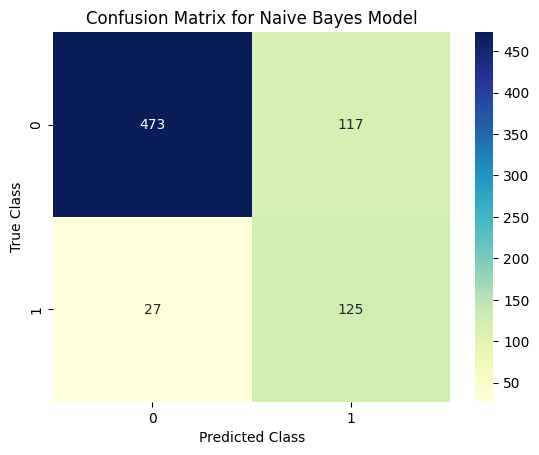

In [ ]:
# Confusion matrix from the output
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu", fmt='.0f')
plt.title("Confusion Matrix for Naive Bayes Model")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

**SVM classfification**

In [ ]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col

# create a LinearSVC model with the specified parameters
svm = LinearSVC(maxIter=10, regParam=0.1)

# fit the SVM model to the training data
model2 = svm.fit(train)

# make predictions on the testing data using the trained model
predict2 = model2.transform(test)

# evaluate the model using the binary classification evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
auc = evaluator.evaluate(predict2)

# print the area under the ROC curve
print("Area under ROC = {}".format(auc))


Area under ROC = 0.9994424620874219


In [ ]:
# create a confusion matrix using the MulticlassMetrics class
predict_and_label = predict2.select("prediction", "label").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predict_and_label)
confusion_matrix2 = metrics.confusionMatrix().toArray()
print("Confusion matrix:\n", confusion_matrix2)


/content/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion matrix:
 [[589.   1.]
 [ 25. 127.]]


In [ ]:
# Extract the TP, TN, FP, and FN values from the confusion matrix
tp = confusion_matrix2[1,1]
print(tp)
tn = confusion_matrix2[0,0]
fp = confusion_matrix2[0,1]
fn = confusion_matrix2[1,0]
# Calculate precision, recall (TPR), specificity (TNR), and accuracy
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the results
print("Precision:", precision)
print("Recall (TPR):", recall)
print("Specificity (TNR):", specificity)
print("Accuracy:", accuracy)
print("F1 Score:", f1_score)

127.0
Precision: 0.9921875
Recall (TPR): 0.8355263157894737
Specificity (TNR): 0.9983050847457627
Accuracy: 0.9649595687331537
F1 Score: 0.9071428571428571


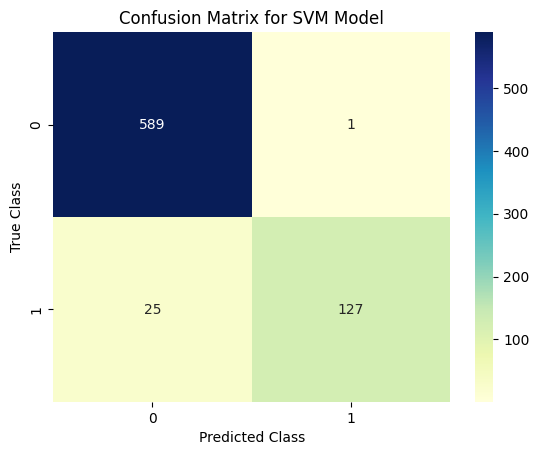

In [ ]:
# Confusion matrix from the output

import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(confusion_matrix2, annot=True, cmap="YlGnBu", fmt='.0f')
plt.title("Confusion Matrix for SVM Model")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()